Process the raw data

In [ ]:
# Load in data from eirgrid_data folder xlsx files
# iterate through the eirgrid_data folder and if it is a xlsx file load it in and print shape of the dataframe
import os 
import pandas as pd
import numpy
dataframes = []
for file in os.listdir('eirgrid_data/raw'):
    if file[-5:] == '.xlsx':
        df = pd.read_excel(f'eirgrid_data/raw/{file}')
        
        # select only the columns up to SNSP column
        df = df.loc[:, :'SNSP']

        print(file, df.shape)

        dataframes.append((df, file, df.shape))





System-Data-Qtr-Hourly-2014-2015.xlsx (70080, 13)
System-Data-Qtr-Hourly-2016-2017.xlsx (70176, 13)
System-Data-Qtr-Hourly-2018-2019.xlsx (70080, 15)
System_Data_Qtr_Hourly_2024.xlsx (35136, 37)
System-Data-Qtr-Hourly-2022-2023_0.xlsx (70080, 37)
System-Data-Qtr-Hourly-2020-2021.xlsx (70176, 15)
System_Data_Qtr_Hourly_2025_1.xlsx (20348, 37)


In [32]:

year_sorted_dfs = []
for df_tuple in dataframes:
    df, file, shape = df_tuple

    # removing information columns at the end
    df = df.loc[:, :'SNSP']
    
    # splitting each data frame into their years
    if shape[0] > 35136:
        years = df['DateTime'].dt.year.unique()
        print(file, years)

        if df['DateTime'].dt.year.iloc[35040] != df['DateTime'].dt.year.iloc[35040 - 1]:
            split = 35040
        elif df['DateTime'].dt.year.iloc[35136] != df['DateTime'].dt.year.iloc[35136 - 1]:
            split = 35136
        else:
            print('split not found')
        # splitting the dataframe at this indice and appending it to year_sorted_dfs
        first_year_df = df.iloc[:split,:]
        second_year_df = df.iloc[split:,:]
        year_sorted_dfs.append((first_year_df, years[0], first_year_df.shape))
        year_sorted_dfs.append((second_year_df, years[1], second_year_df.shape))

            # print(year, year_df.shape)
    else:
        years = df['DateTime'].dt.year.unique()
        year_sorted_dfs.append((df, years[0], shape))



System-Data-Qtr-Hourly-2014-2015.xlsx [2014 2015]
System-Data-Qtr-Hourly-2016-2017.xlsx [2016 2017]
System-Data-Qtr-Hourly-2018-2019.xlsx [2018 2019]
System-Data-Qtr-Hourly-2022-2023_0.xlsx [2022 2023]
System-Data-Qtr-Hourly-2020-2021.xlsx [2020 2021]


In [36]:
for df_tuple in year_sorted_dfs:
    df, year, shape = df_tuple
    print(year, shape)
    df.to_csv(f'eirgrid_data/cleaned/{year}.csv', index=False)


2014 (35040, 11)
2015 (35040, 11)
2016 (35136, 11)
2017 (35040, 11)
2018 (35040, 13)
2019 (35040, 13)
2024 (35136, 37)
2022 (35040, 34)
2023 (35040, 34)
2020 (35136, 13)
2021 (35040, 13)
2025 (20348, 37)


Process from cleaned data into data averaged to the hour 

In [4]:
import os
import pandas as pd

years = {}
columns = set()

for file in os.listdir('eirgrid_data/cleaned'):
    if file[-4:] == '.csv':
        df = pd.read_csv(f'eirgrid_data/cleaned/{file}')
        print(file, df.shape)

        # build a matrix to be shown of the data fields available for each year which is the file name
        years[file[:-4]] = df.columns.tolist()
        for col in df.columns:
            columns.add(col)
columns_present_df = pd.DataFrame(columns=['Year'] + list(columns))
for year, cols in years.items():
    col_present = []
    for col in columns:
        if col in cols:
            col_present.append(1)
        else:
            col_present.append(0)
    columns_present_df.loc[len(columns_present_df)] = [year] + col_present

columns_present_df = columns_present_df.set_index('Year')
columns_present_df.sort_index(inplace=True) 



2020.csv (35136, 13)
2021.csv (35040, 13)
2023.csv (35040, 34)
2022.csv (35040, 34)
2025.csv (20348, 34)
2019.csv (35040, 13)
2018.csv (35040, 13)
2024.csv (35136, 34)
2015.csv (35040, 11)
2014.csv (35040, 11)
2016.csv (35136, 11)
2017.csv (35040, 11)


In [15]:
columns

{'AI Demand',
 'AI Generation',
 'AI Hydro',
 'AI Oversupply',
 'AI Oversupply Percentage',
 'AI Solar Availability',
 'AI Solar Generation',
 'AI Solar Penetration',
 'AI Wind Availability',
 'AI Wind Generation',
 'AI Wind Penetration',
 'DateTime',
 'EWIC I/C',
 'GMT Offset',
 'IE Demand',
 'IE Generation',
 'IE Hydro',
 'IE Solar Availability',
 'IE Solar Generation',
 'IE Solar Penetration',
 'IE Wind Availability',
 'IE Wind Generation',
 'IE Wind Penetration',
 'Inter-Jurisdictional Flow',
 'Moyle I/C',
 'NI Demand',
 'NI Generation',
 'NI Solar Availability',
 'NI Solar Generation',
 'NI Solar Penetration',
 'NI Wind Availability',
 'NI Wind Generation',
 'NI Wind Penetration',
 'SNSP'}

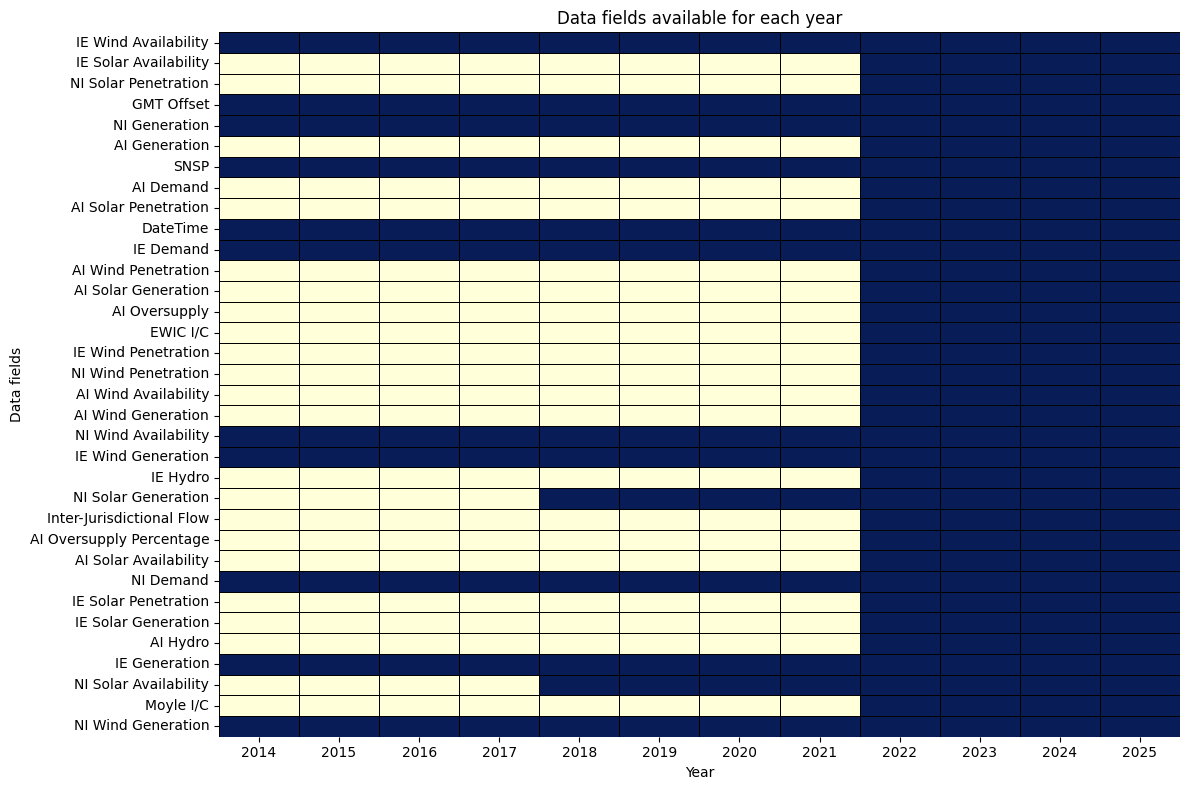

In [13]:
# need to show this data frame as a matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(columns_present_df.T, cmap='YlGnBu', cbar=False, linewidths=0.5, linecolor='black')
plt.title('Data fields available for each year')
plt.xlabel('Year')
plt.ylabel('Data fields')
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

def interpolate_numerical(df, column, hour_index):
    """
    Interpolate numerical values by averaging within each hour
    """
    # Use the pre-calculated hour index to group and calculate mean
    
    return df.groupby(hour_index)[column].mean()

def interpolate_categorical(df, column, hour_index):
    """
    Interpolate categorical values using majority voting within each hour
    In case of ties, select the first value that appears in that hour
    """
    # Use the pre-calculated hour index to group and get mode
    def get_majority(x):
        # Get value counts
        counts = x.value_counts()
        # Return the most frequent value (first one in case of ties)
        return counts.index[0]
    
    return df.groupby(hour_index)[column].apply(get_majority)

def process_file(file_path):
    """
    Process a single CSV file applying the appropriate interpolation method
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert DateTime column to datetime
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    
    # Create hour index once
    hour_index = df['DateTime'].dt.floor('h')
    
    # Initialize processed dataframe with hourly DateTime
    df_processed = pd.DataFrame({'DateTime': hour_index.unique()})
    
    # Process each column based on its dtype
    for column in df.columns:
        if column == 'DateTime':
            continue  # DateTime is already processed
        elif df[column].dtype == int:
            # For int columns, use categorical interpolation
            df_processed[column] = list(interpolate_categorical(df, column, hour_index))
        else:
            # For object of other types, treat as categorical
            df_processed[column] = list(interpolate_numerical(df, column, hour_index))
    
    return df_processed

"""
Process all CSV files in the eirgrid_data/cleaned folder
"""
input_folder = 'eirgrid_data/cleaned'
output_folder = 'eirgrid_data/hourly_cleaned'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process each CSV file
for filename in os.listdir(input_folder):
    if filename.endswith('.csv'):
        print(f"Processing {filename}...")
        
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, f"hourly_{filename}")
        
        # Process the file
        df_processed = process_file(input_path)
        
        # Save the processed file
        df_processed.to_csv(output_path, index=False)
        print(f"Saved processed file to {output_path}")
        


Processing 2020.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2020.csv
Processing 2021.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2021.csv
Processing 2023.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2023.csv
Processing 2022.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2022.csv
Processing 2025.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2025.csv
Processing 2019.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2019.csv
Processing 2018.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2018.csv
Processing 2024.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2024.csv
Processing 2015.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2015.csv
Processing 2014.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2014.csv
Processing 2016.csv...
Saved processed file to eirgrid_data/hourly_cleaned/hourly_2016.csv